In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def show_history(h):
    epochs = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), h.history.get('accuracy'), label="Training")
    plt.plot(range(1, epochs+1), h.history.get('val_accuracy'), label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), h.history.get('loss'), label="Training")
    plt.plot(range(1, epochs+1), h.history.get('val_loss'), label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [88]:
def show_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred, normalize='true')
  
  plt.figure(figsize=(8, 8))
  sp = plt.subplot(1, 1, 1)
  ctx = sp.matshow(cm)
  plt.xticks(list(range(0, 6)), labels=classes)
  plt.yticks(list(range(0, 6)), labels=classes)
  plt.colorbar(ctx)
  plt.show()

In [ ]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_data_labels(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
x_train, y_train = get_data_labels(train)
x_val, y_val = get_data_labels(val)
x_test, y_test = get_data_labels(test)

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(x_train)

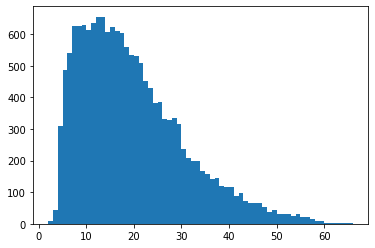

In [ ]:
lengths = [len(t.split(' ')) for t in x_train]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [29]:
max_len = 50

In [30]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded_sequences = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')
  return padded_sequences

In [31]:
padded_train_seq = get_sequences(tokenizer, x_train)

In [36]:
classes = set(y_train)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

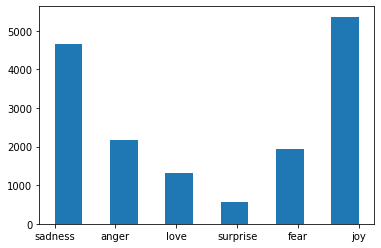

In [40]:
plt.hist(y_train, bins=11)
plt.show()

In [41]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [44]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [45]:
y_train = names_to_ids(y_train)

In [60]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000, 16, input_length=max_len),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, activation='tanh', return_sequences='true')),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, activation='tanh')),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [53]:
x_val = get_sequences(tokenizer, x_val)
y_val = names_to_ids(y_val)

In [62]:
h = model.fit(padded_train_seq, y_train, validation_data=(x_val, y_val), epochs=25,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)])

Epoch 1/25
500/500 [==============================] - 10s 17ms/step - loss: 1.2841 - accuracy: 0.4971 - val_loss: 0.7609 - val_accuracy: 0.7375
Epoch 2/25
500/500 [==============================] - 8s 15ms/step - loss: 0.5458 - accuracy: 0.8066 - val_loss: 0.6040 - val_accuracy: 0.7990
Epoch 3/25
500/500 [==============================] - 8s 16ms/step - loss: 0.3257 - accuracy: 0.8948 - val_loss: 0.4102 - val_accuracy: 0.8625
Epoch 4/25
500/500 [==============================] - 8s 16ms/step - loss: 0.2202 - accuracy: 0.9335 - val_loss: 0.4450 - val_accuracy: 0.8625
Epoch 5/25
500/500 [==============================] - 8s 16ms/step - loss: 0.1662 - accuracy: 0.9496 - val_loss: 0.3707 - val_accuracy: 0.8820
Epoch 6/25
500/500 [==============================] - 7s 15ms/step - loss: 0.1234 - accuracy: 0.9620 - val_loss: 0.3502 - val_accuracy: 0.8920
Epoch 7/25
500/500 [==============================] - 8s 15ms/step - loss: 0.1006 - accuracy: 0.9694 - val_loss: 0.3786 - val_accuracy: 0.877

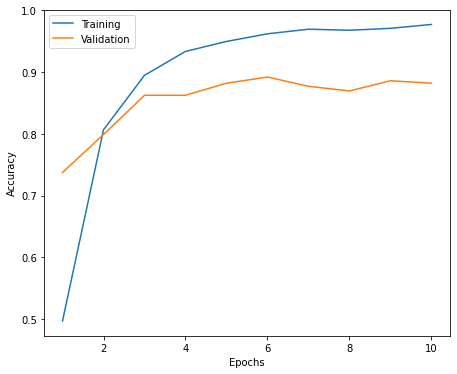

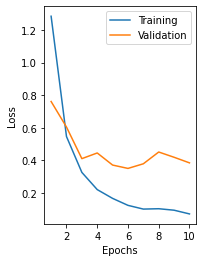

In [63]:
show_history(h)

In [64]:
x_test = get_sequences(tokenizer, x_test)
y_test = names_to_ids(y_test)

In [66]:
_ = model.evaluate(x_test, y_test)

63/63 [==============================] - 0s 7ms/step - loss: 0.4011 - accuracy: 0.8815


In [85]:
for _ in range(10):
  x = random.randint(0, len(x_test)-1)
  print(f"Sentence: {test[x]['text']}")
  print(f'Emotion: {index_to_class[y_test[x]]}')
  prediction = model.predict(np.expand_dims(x_test[x], axis=0))[0]
  pred = index_to_class[np.argmax(prediction)]
  print(f"Prediction: {pred}")
  print()

Sentence: i feel most inspired to create and ive been thinking a lot about inspiration this week
Emotion: joy
Prediction: joy

Sentence: i indicated then i was feeling quite overwhelmed with work responsibilities teaching traveling and writing
Emotion: fear
Prediction: surprise

Sentence: i just cant help but feel like i must protect this innocent being
Emotion: joy
Prediction: joy

Sentence: whenever i put myself in others shoes and try to make the person happy
Emotion: anger
Prediction: sadness

Sentence: i never dreamed i would be so busy so soon in the new year but i am loving it and feeling so very gracious and fortunate
Emotion: joy
Prediction: love

Sentence: i think and it feels a little weird
Emotion: fear
Prediction: fear

Sentence: i can feel the warmth of the gentle sun
Emotion: love
Prediction: love

Sentence: i kept trying to make her feel better
Emotion: joy
Prediction: joy

Sentence: i feel like the crows and roosters will be teamed up with the horses and go against the

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


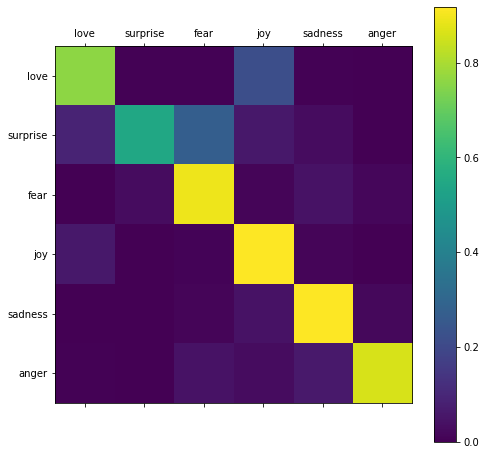

In [89]:
preds = model.predict_classes(x_test)
show_confusion_matrix(y_test, preds, list(classes))